<a href="https://colab.research.google.com/github/chakma21/BTP/blob/main/Exploringlib/generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving HW_keybert_keywords.csv to HW_keybert_keywords.csv
Sample of keywords: ['york accuses weinstein', 'harvey weinsteins alleged', 'harvey weinstein allegations', 'weinsteins alleged sexual', 'accusations rape weinstein', 'accuses weinstein raping', 'accuses harvey weinsteins', 'weinstein charged rape', 'harvey weinstein accused', 'allegations harvey weinstein']


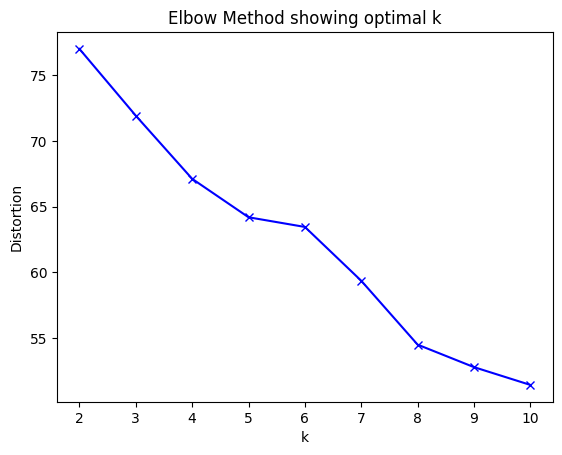


Cluster 'weinsteins alleged misconduct':
Contains 12 items.
['harvey weinsteins alleged', 'weinsteins sexual conduct', 'weinstein sexual misconduct', 'weinsteins alleged behaviour', 'harvey weinstein misconduct', 'weinsteins alleged misconduct', 'weinsteins alleged', 'weinstein alleged', 'misconduct harvey weinstein', 'sues weinstein alleged', 'know weinsteins alleged', 'weinstein misconduct']

Cluster 'weinstein raped weinstein':
Contains 46 items.
['york accuses weinstein', 'accusations rape weinstein', 'accuses weinstein raping', 'accuses harvey weinsteins', 'weinstein charged rape', 'harvey weinstein accused', 'harvey weinstein investigation', 'accused harvey weinsteindawn', 'claims weinstein raped', 'harvey weinstein raped', 'accuses weinstein harassment', 'harvey weinstein accuser', 'harvey weinstein charged', 'weinstein raped weinstein', 'weinstein accused', 'yorker claims weinstein', 'raped harvey weinstein', 'rape weinstein', 'raped weinstein forcibly', 'weinstein raped', 'ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

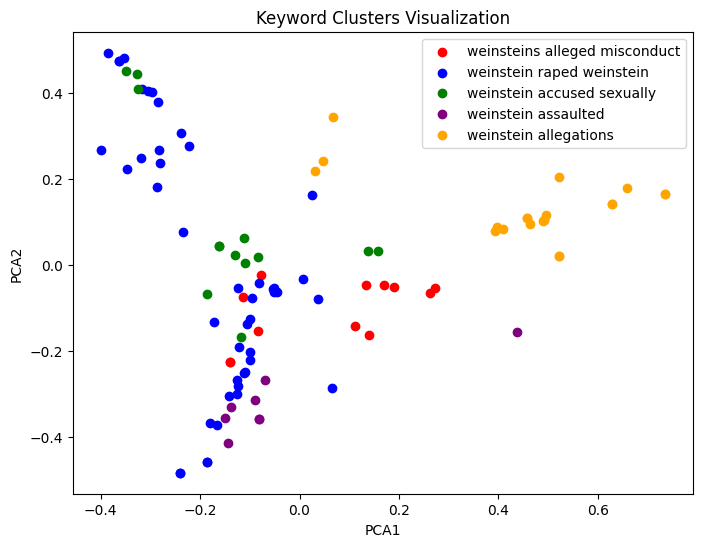

In [10]:
# !pip install scikit-learn pandas numpy openpyxl

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import io

# Step 1: Upload your CSV (should have two columns: score,keyword)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Read the file as CSV with header or without, and extract keywords only
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    # Try to find column named 'keyword' (case-insensitive)
    keyword_col = [col for col in df.columns if 'keyword' in col.lower()]
    if keyword_col:
        keywords = df[keyword_col[0]].astype(str).tolist()
    else:
        # Assume second column is keyword if header missing
        keywords = df.iloc[:,1].astype(str).tolist()
except Exception:
    # fallback to simple read: assumes score,keyword with comma separation
    lines = io.StringIO(uploaded[filename].decode('utf-8')).read().splitlines()
    keywords = [line.split(',')[1] for line in lines if ',' in line]

keywords = [k.strip() for k in keywords if k.strip()]
print("Sample of keywords:", keywords[:10])

# Step 3: TF-IDF vectorization
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))
X = vectorizer.fit_transform(keywords)

# Step 4: Elbow method
def plot_elbow(X, max_k=10):
    distortions = []
    K = range(2, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method showing optimal k')
    plt.show()

plot_elbow(X, max_k=10)

# Step 5: Choose k
k = 5  # set as needed

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

# Step 6: Cluster representative (phrase, not score)
clustered = pd.DataFrame({'Keyword': keywords, 'Cluster': labels})
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
cluster_names = [keywords[idx] for idx in closest]
clustered['Cluster Name'] = clustered['Cluster'].map(lambda x: cluster_names[x])

# Step 7: Print all clusters with representative phrase as the heading
for i, name in enumerate(cluster_names):
    print(f"\nCluster '{name}':")
    cluster_items = clustered[clustered['Cluster']==i]['Keyword'].tolist()
    print(f"Contains {len(cluster_items)} items.")
    print(cluster_items)

# Step 8: Save results and download
excel_filename = "clustered_keywords.xlsx"
# csv_filename = "clustered_keywords.csv"
clustered.to_excel(excel_filename, index=False)
# clustered.to_csv(csv_filename, index=False)
files.download(excel_filename)
# files.download(csv_filename)

# Optional: Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, name in enumerate(cluster_names):
    idxs = clustered['Cluster'] == i
    plt.scatter(X_pca[idxs,0], X_pca[idxs,1], c=colors[i%len(colors)], label=name)
plt.legend()
plt.title('Keyword Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()